[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


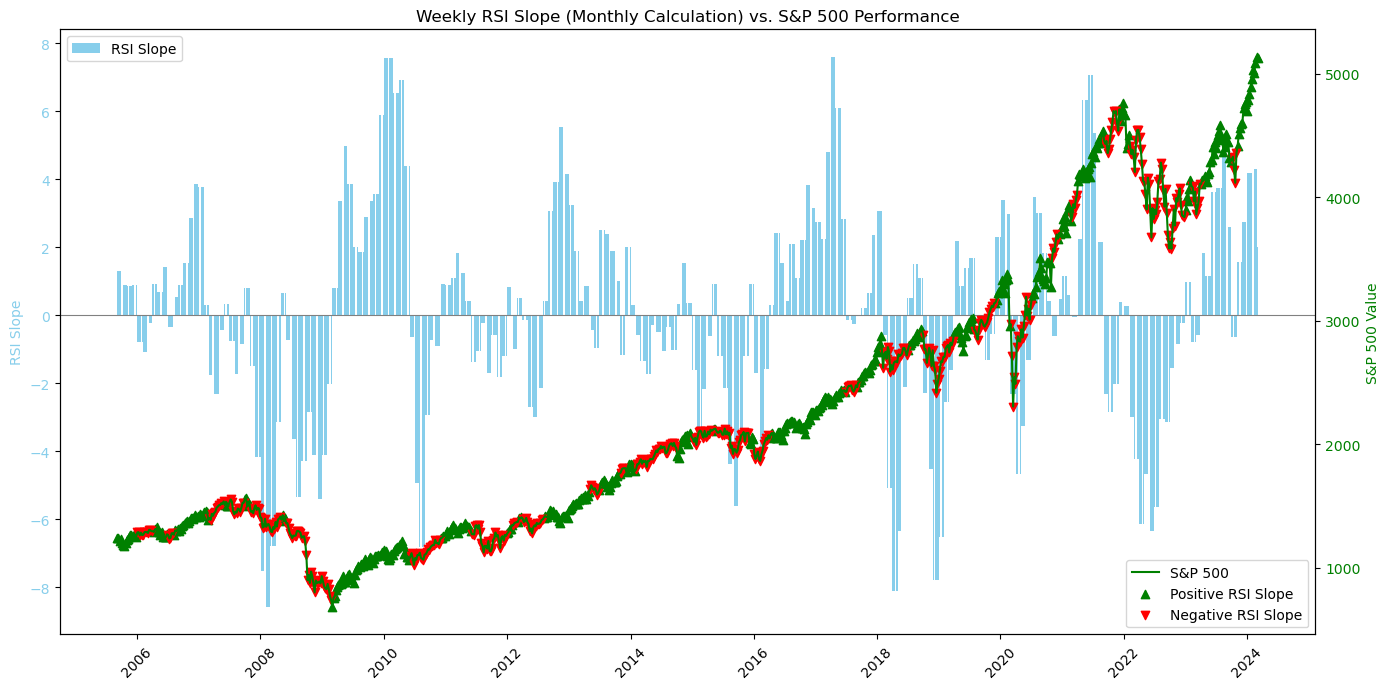

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Fetch S&P 500 data for 20 years with monthly and weekly intervals
sp500_monthly = yf.download('^GSPC', period="20y", interval="1mo")
sp500_weekly = yf.download('^GSPC', period="20y", interval="1wk")

# Calculate RSI and its slope for the monthly data
sp500_monthly['RSI'] = calculate_rsi(sp500_monthly['Adj Close'], window=14)
sp500_monthly['RSI_Slope'] = sp500_monthly['RSI'].rolling(window=5).apply(
    lambda x: linregress(range(len(x)), x).slope if not x.isnull().any() else np.nan)

# Prepare the weekly data for merging
sp500_weekly.reset_index(inplace=True)
sp500_weekly['Month'] = sp500_weekly['Date'].dt.to_period('M')
sp500_monthly['Month'] = sp500_monthly.index.to_period('M')

# Merge the monthly RSI slope into the weekly data
monthly_slope = sp500_monthly[['Month', 'RSI_Slope']].dropna()
sp500_weekly = pd.merge(sp500_weekly, monthly_slope, on='Month', how='left')

# Forward fill the monthly RSI slope values into each week
sp500_weekly['RSI_Slope'].ffill(inplace=True)

# Ensure all rows with missing RSI Slope values are dropped
sp500_weekly.dropna(subset=['RSI_Slope'], inplace=True)

# Plotting with corrected dates on the x-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Configure x-axis to display dates correctly
ax1.xaxis_date()  # Ensure we're using dates on the x-axis
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
plt.xticks(rotation=45)

# Plot RSI Slope as weekly bars
ax1.bar(sp500_weekly['Date'], sp500_weekly['RSI_Slope'], width=5, color='skyblue', label='RSI Slope')
ax1.axhline(0, color='gray', linewidth=0.8)
ax1.set_ylabel('RSI Slope', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for the S&P 500 values
ax2 = ax1.twinx()
ax2.plot(sp500_weekly['Date'], sp500_weekly['Adj Close'], color='green', label='S&P 500')
ax2.set_ylabel('S&P 500 Value', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add markers for positive or negative RSI Slope
positive_slope = sp500_weekly['RSI_Slope'] > 0
negative_slope = sp500_weekly['RSI_Slope'] < 0
ax2.scatter(sp500_weekly[positive_slope]['Date'], sp500_weekly[positive_slope]['Adj Close'], color='green', marker='^', label='Positive RSI Slope')
ax2.scatter(sp500_weekly[negative_slope]['Date'], sp500_weekly[negative_slope]['Adj Close'], color='red', marker='v', label='Negative RSI Slope')

ax2.legend(loc='lower right')

plt.title('Weekly RSI Slope (Monthly Calculation) vs. S&P 500 Performance')
plt.tight_layout()
plt.show()
